# Mappa bella dell'Italia

In [1]:
import numpy as np
import pandas as pd

import geopandas as gpd
import contextily as ctx

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import esda

from pysal.lib import  weights

from splot.esda import moran_scatterplot, lisa_cluster, plot_local_autocorrelation, plot_moran
from splot.libpysal import plot_spatial_weights

In [2]:
Reg = gpd.read_file("data/regioni_db/regioni.shp")
Reg.head(1)

,COD_RIP,COD_REG,DEN_REG,Shape_Leng,Shape_Area,persone,n_menzione,n_bronzo,n_argento,n_oro,n_medaglie,r_menzione,r_bronzo,r_argento,r_oro,r_medaglie,pos_media,pos_median,geometry
0,1,1,Piemonte,1.234644e+06,2.539164e+10,414,81,100,82,35,217,0.195652,0.241546,0.198068,0.084541,0.524155,138.094203,131.0,"POLYGON ((457749.464 5145501.795, 458662.395 5..."


In [3]:
# Prima matrice di pesi
w = weights.Queen.from_dataframe(Reg, ids="DEN_REG")

# Metto un nuovo indice al dataset
Reg = Reg.set_index("DEN_REG", drop=False)

# Creo un dataset senza le isole
RegNoIsla = Reg.drop(w.islands)

# e ricalcolo la matrice di pesi
w = weights.Queen.from_dataframe(RegNoIsla, ids="DEN_REG")
# normalizzata con righe a somma 1
w.transform = "R"

C:\Users\micbe\AppData\Roaming\Python\Python312\site-packages\libpysal\weights\contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
 There are 2 islands with ids: Sicilia, Sardegna.
  W.__init__(self, neighbors, ids=ids, **kw)


In [4]:
# Aggiungo alcune colonne utili

# medaglie in percentuale
RegNoIsla["r_medaglie_100"] = RegNoIsla["r_medaglie"] * 100

# la media dei vicini (lag spaziale)
RegNoIsla["w_r_medaglie"] = weights.lag_spatial(w, RegNoIsla["r_medaglie"])

# le medaglie standardizzate
RegNoIsla["r_medaglie_std"] = ( RegNoIsla["r_medaglie"] - RegNoIsla["r_medaglie"].mean() ) / RegNoIsla["r_medaglie"].std()

# i lag spaziali standardizzati
RegNoIsla["w_r_medaglie_std"] = weights.lag_spatial(w, RegNoIsla["r_medaglie_std"])

In [5]:
RegNoIsla = RegNoIsla[["DEN_REG", "r_medaglie_100", "r_medaglie", "w_r_medaglie", "r_medaglie_std", "w_r_medaglie_std", "geometry"]]
RegNoIsla.head(2)

,DEN_REG,r_medaglie_100,r_medaglie,w_r_medaglie,r_medaglie_std,w_r_medaglie_std,geometry
DEN_REG,,,,,,,
Piemonte,Piemonte,52.415459,0.524155,0.453314,0.590769,0.089670,"POLYGON ((457749.464 5145501.795, 458662.395 5..."
Valle d'Aosta,Valle d'Aosta,18.750000,0.187500,0.524155,-1.790590,0.590769,"POLYGON ((390652.643 5091766.170, 390748.643 5..."


In [6]:
# Creiamo lisa (indicatore locale di aggregazione spaziale)
lisa = esda.Moran_Local(RegNoIsla["r_medaglie"], w, permutations=5000) #, seed=126)

# Creo la colonna coi p_sim di ogni regione
RegNoIsla["p_sim"] = lisa.p_sim

# Creo la colonna coi quadranti
RegNoIsla["quadr"] = lisa.q

RegNoIsla

,DEN_REG,r_medaglie_100,r_medaglie,w_r_medaglie,r_medaglie_std,w_r_medaglie_std,geometry,p_sim,quadr
DEN_REG,,,,,,,,,
Piemonte,Piemonte,52.415459,0.524155,0.453314,0.590769,0.089670,"POLYGON ((457749.464 5145501.795, 458662.395 5...",0.424715,1
Valle d'Aosta,Valle d'Aosta,18.750000,0.187500,0.524155,-1.790590,0.590769,"POLYGON ((390652.643 5091766.170, 390748.643 5...",0.173765,2
Lombardia,Lombardia,60.575540,0.605755,0.530140,1.167980,0.633110,"MULTIPOLYGON (((485536.498 4985444.636, 485366...",0.047191,1
Trentino-Alto Adige,Trentino-Alto Adige,50.413223,0.504132,0.599015,0.449139,1.120301,"POLYGON ((743273.909 5219762.939, 743387.812 5...",0.024795,1
Veneto,Veneto,59.227468,0.592275,0.563094,1.072623,0.866208,"POLYGON ((768135.209 5175357.497, 768136.788 5...",0.007598,1
Friuli-Venezia Giulia,Friuli-Venezia Giulia,64.248705,0.642487,0.592275,1.427805,1.072623,"MULTIPOLYGON (((871036.678 5066768.855, 871032...",0.117576,1
Liguria,Liguria,52.000000,0.520000,0.516028,0.561381,0.533285,"MULTIPOLYGON (((568227.844 4874810.869, 568220...",0.156769,1
Emilia-Romagna,Emilia-Romagna,50.000000,0.500000,0.521243,0.419909,0.570174,"MULTIPOLYGON (((618343.929 4893985.660, 618335...",0.037193,1
Toscana,Toscana,52.392947,0.523929,0.464984,0.589176,0.172220,"MULTIPOLYGON (((674479.640 4680664.861, 674610...",0.302539,1


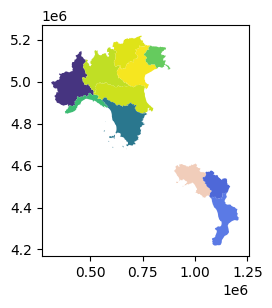

In [7]:
# Questo era un test, che sembra funzionare
fig, ax = plt.subplots(1, figsize=(3, 3))

hh = RegNoIsla[RegNoIsla["quadr"]==1]
hh.plot(ax=ax, column="p_sim", cmap="viridis_r", vmax=0.5, vmin=0)

hh = RegNoIsla[RegNoIsla["quadr"]==3]
hh.plot(ax=ax, column="p_sim", cmap="coolwarm", vmax=0.5, vmin=0);

## Ora creo le colormaps

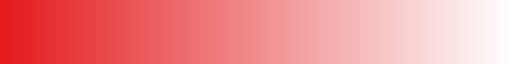

In [8]:
colors_hh = ["#E41A1C", "White"]
cmap_hh = mpl.colors.LinearSegmentedColormap.from_list("cmap_hh", colors_hh)
cmap_hh

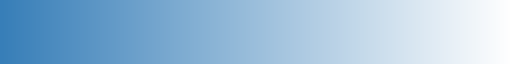

In [9]:
colors_ll = ["#377EB8", "White"]
cmap_ll = mpl.colors.LinearSegmentedColormap.from_list("cmap_ll", colors_ll)
cmap_ll

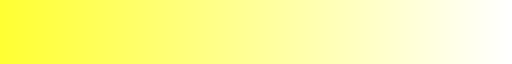

In [10]:
colors_hl = ["#FFFF33", "White"]
cmap_hl = mpl.colors.LinearSegmentedColormap.from_list("cmap_hl", colors_hl)
cmap_hl

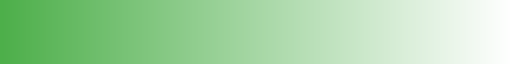

In [21]:
colors_lh = ["#4DAF4A", "White"]
cmap_lh = mpl.colors.LinearSegmentedColormap.from_list("cmap_lh", colors_lh)
cmap_lh

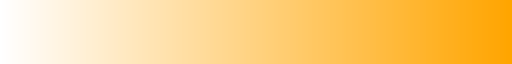

In [12]:
colors_general = ["White", "Orange"]
cmap_general = mpl.colors.LinearSegmentedColormap.from_list("cmap_general", colors_general)
cmap_general

# Grafico completo

In [13]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [14]:
Reg["R_medaglie"] = Reg["r_medaglie"] * 100

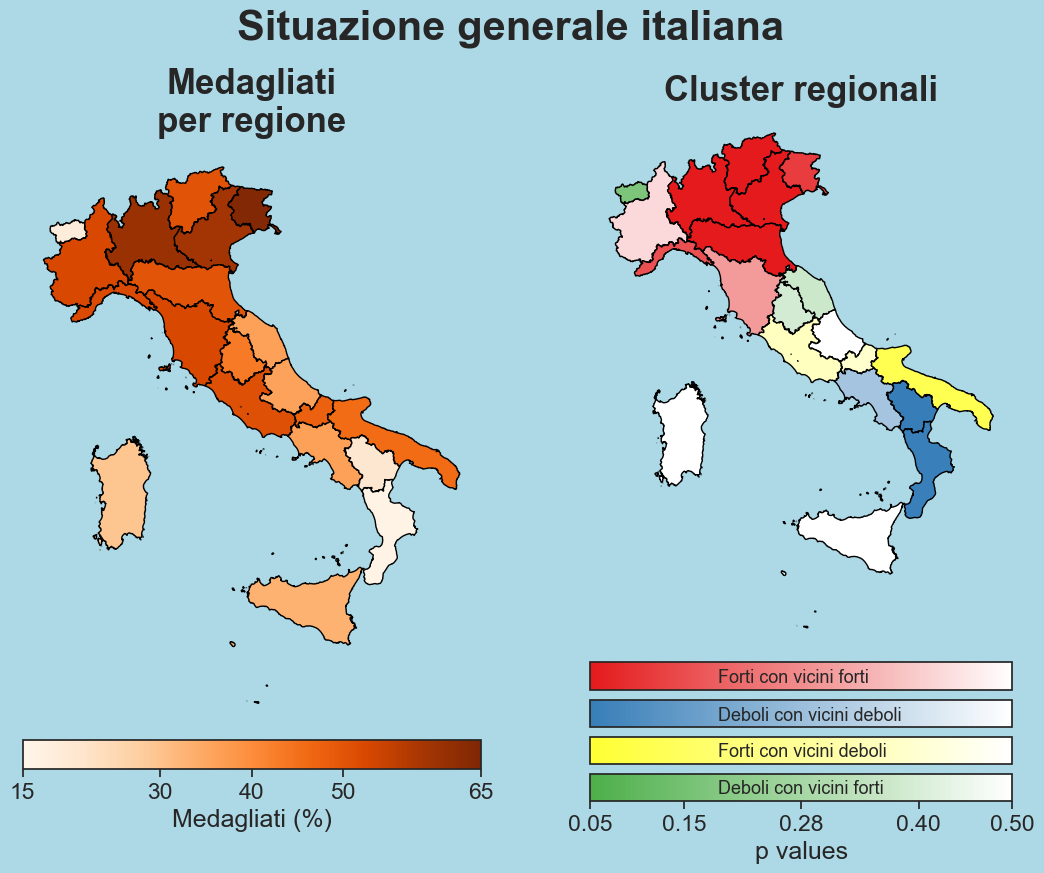

In [22]:
sns.set( style="white", font_scale=1.5 )

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(13, 9))

soglia_sig = 0.5
col_bordo = "Black"
spes_bordo = 1

# Parte 1 del grafico

divider1 = make_axes_locatable(ax1)
cax1 = divider1.append_axes("bottom", size="5%", pad=0.1)

Reg.plot(
    ax=ax1,
    column="R_medaglie",
    
    cmap="Oranges",
    
    edgecolor=col_bordo,
    linewidth=spes_bordo,

    vmin=15,
    vmax=65,
    legend=True,
    cax=cax1,
    legend_kwds={"label": "Medagliati (%)", "orientation": "horizontal", "format": "%.f",
                 "ticks": [15, 30, 40, 50, 65]}
)
ax1.set_title("Medagliati\nper regione", fontweight="bold", fontsize=25)
ax1.set_axis_off()


# parte 2 del grafico

div2 = make_axes_locatable(ax2)
cax_hh = div2.append_axes("bottom", size="5%", pad=0.1)
cax_ll = div2.append_axes("bottom", size="5%", pad=0.1)
cax_hl = div2.append_axes("bottom", size="5%", pad=0.1)
cax_lh = div2.append_axes("bottom", size="5%", pad=0.1)

hh = RegNoIsla[RegNoIsla["quadr"]==1]
hh.plot(
    ax=ax2,
    column="p_sim",
        
    cmap=cmap_hh,
    vmin=0.05, vmax=soglia_sig,

    edgecolor=col_bordo,
    linewidth=spes_bordo,

    legend=True,
    cax=cax_hh,
    legend_kwds={"orientation": "horizontal", "format": "%.2f",
                 "ticks": []}
)

ll = RegNoIsla[RegNoIsla["quadr"]==3]
ll.plot(
    ax=ax2,
    column="p_sim",
        
    cmap=cmap_ll,
    vmin=0.05, vmax=soglia_sig,

    edgecolor=col_bordo,
    linewidth=spes_bordo,

    legend=True,
    cax=cax_ll,
    legend_kwds={"orientation": "horizontal", "format": "%.2f",
                 "ticks": []}
)

lh = RegNoIsla[RegNoIsla["quadr"]==2]
lh.plot(
    ax=ax2,
    column="p_sim",
        
    cmap=cmap_lh,
    vmin=0.05, vmax=soglia_sig,

    edgecolor=col_bordo,
    linewidth=spes_bordo,

    legend=True,
    cax=cax_lh,
    legend_kwds={"label": "p values", "orientation": "horizontal", "format": "%.2f",
                 "ticks": [0.05, 0.15, 0.275, 0.4, soglia_sig]}
)

hl = RegNoIsla[RegNoIsla["quadr"]==4]
hl.plot(
    ax=ax2,
    column="p_sim",
        
    cmap=cmap_hl,
    vmin=0.05, vmax=soglia_sig,

    edgecolor=col_bordo,
    linewidth=spes_bordo,

    legend=True,
    cax=cax_hl,
    legend_kwds={"orientation": "horizontal", "format": "%.2f",
                 "ticks": []}
)

ns = Reg[ (Reg["DEN_REG"]=="Sardegna") | (Reg["DEN_REG"]=="Sicilia") ]
ns.plot(
    ax=ax2,
    color="White",

    edgecolor=col_bordo,
    linewidth=spes_bordo,
    
    legend=False
)

ax2.set_title("Cluster regionali", fontweight="bold", fontsize=25)
ax2.set_axis_off()

# etichetta colorbar
fig.text(0.66, 0.242, "Forti con vicini forti", fontsize=13,
        transform=fig.transFigure, ha="left")
fig.text(0.66, 0.2, "Deboli con vicini deboli", fontsize=13,
        transform=fig.transFigure, ha="left")
fig.text(0.66, 0.16, "Forti con vicini deboli", fontsize=13,
        transform=fig.transFigure, ha="left")
fig.text(0.66, 0.119, "Deboli con vicini forti", fontsize=13,
        transform=fig.transFigure, ha="left")

# info generali

fig.suptitle("Situazione generale italiana", fontweight="bold", fontsize=30, y=0.99)
fig.set_facecolor("LightBlue");

# Salvataggio figura
plt.savefig("image/MedaglieItalia.png", bbox_inches="tight", pad_inches=0.3, transparent=False)
plt.savefig("image/MedaglieItalia.svg", bbox_inches="tight", pad_inches=0.3, transparent=False)

In [16]:
Reg.describe()

,COD_RIP,COD_REG,Shape_Leng,Shape_Area,persone,n_menzione,n_bronzo,n_argento,n_oro,n_medaglie,r_menzione,r_bronzo,r_argento,r_oro,r_medaglie,pos_media,pos_median,R_medaglie
count,20.000000,20.00000,2.000000e+01,2.000000e+01,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,2.900000,10.50000,9.223607e+05,1.510347e+10,240.850000,47.150000,56.450000,40.650000,20.200000,117.300000,0.214643,0.210013,0.153791,0.064100,0.427903,154.681786,154.900000,42.790341
std,1.333772,5.91608,3.399314e+05,7.448508e+09,180.889985,31.576599,47.936883,40.176289,22.054001,108.822453,0.042110,0.067114,0.066576,0.041653,0.139458,26.183383,34.483635,13.945795
min,1.000000,1.00000,3.111871e+05,3.258608e+09,16.000000,5.000000,0.000000,2.000000,0.000000,3.000000,0.145078,0.000000,0.038462,0.000000,0.161538,116.746114,105.000000,16.153846
25%,2.000000,5.75000,6.192655e+05,9.124399e+09,116.250000,25.000000,21.000000,9.750000,2.750000,31.250000,0.188082,0.195860,0.091373,0.026786,0.353068,138.290080,133.000000,35.306756
50%,3.000000,10.50000,8.689610e+05,1.444025e+10,171.500000,28.500000,48.500000,29.000000,12.000000,93.500000,0.210449,0.216358,0.175557,0.064259,0.466764,148.659204,149.500000,46.676418
75%,4.000000,15.25000,1.195876e+06,2.262262e+10,385.750000,76.000000,95.250000,70.000000,28.500000,195.250000,0.233037,0.258146,0.199516,0.085947,0.520982,172.066028,175.500000,52.098237
max,5.000000,20.00000,1.449231e+06,2.582432e+10,695.000000,104.000000,183.000000,157.000000,81.000000,421.000000,0.312500,0.295337,0.247934,0.139896,0.642487,213.623077,230.000000,64.248705


In [17]:
w["Lazio"]

{'Campania': 0.16666666666666666,
 'Marche': 0.16666666666666666,
 'Toscana': 0.16666666666666666,
 'Umbria': 0.16666666666666666,
 'Abruzzo': 0.16666666666666666,
 'Molise': 0.16666666666666666}

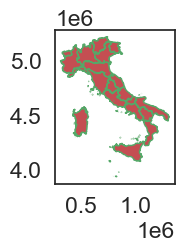

In [18]:
f, ax = plt.subplots(figsize=(2, 2))
Reg.plot(ax=ax,
        color="r",
        edgecolor="g");